# MNIST 1.0

This document serves as my notes on the Deep Learning Without a PhD seminar by Google. 

* [Video](https://www.youtube.com/watch?v=vq2nnJ4g6N0)
* [Slides - 1](https://docs.google.com/presentation/d/1TVixw6ItiZ8igjp6U17tcgoFrLSaHWQmMOwjlgQY9co/pub?slide=id.p)
* [Slides - 2](https://docs.google.com/presentation/d/e/2PACX-1vRouwj_3cYsmLrNNI3Uq5gv5-hYp_QFdeoan2GlxKgIZRSejozruAbVV0IMXBoPsINB7Jw92vJo2EAM/pub?slide=id.p)

This notebook covers the "first" example, of trying to classify MNIST digits using just a weighted sum of pixel values with a softmax. 

# Setup

## Imports

In [19]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data as mnist_data

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## Load Data

In [20]:
# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


## Setup Model

Lets first make a simple soft-max classification of MNIST digits.

![](../images/model.png)

Take each `28 x 28` image, flatten into a `784` vector, and have that fully connected to a 10-node softmax layer which will serve as our classifier. 

Lets define all our sizes up front for clarity

In [21]:
batchSize = None;       # put None for right now as we dont know yet
imgHeight = 28
imgWidth = 28
numOfColors = 1         # gray scale images
flatSize = imgHeight*imgWidth*numOfColors   # 728
numberOfClasses = 10    # 10 classes: 0-9

Now we can define our variables. Lets begin with our our input images: `X_img`:

In [22]:
# Input Data
X_img = tf.placeholder(tf.float32, [batchSize, imgHeight, imgWidth, numOfColors], name="X_img")

This is a tensor, where we can image a set of photographs stacked vertically across a table of length `batchSize` from left to right. So X_img[0,:,:,:] would be the first image, for example.

We also need to reshape/flatten our input data in `X_img` into an input vector: `X_vec`.  

**Note**: If one component of `shape` is the special value `-1`, the size of that dimension is computed so that the total size remains constant. In particular, a shape of `[-1]` flattens into `1-D`. At most one component of `shape` can be `-1`.

In [23]:
X_vec = tf.reshape(X_img, [-1, 784], name="X_vec")

`X_vec` has the following shape:

![](../images/x_vec.png)

where we see that each image in our batch has been flattened into a row of length: $28*28*1 = 784$ and stacked.

Now we define our weights and biases:

In [24]:
# Weights
W = tf.Variable(tf.zeros([flatSize, numberOfClasses]), name="Weights")

# Biases
b = tf.Variable(tf.zeros([10]), name="Biases")

Now, the effect of multiplying `X_vec` which is $100 \times 784$ by `W` which is $784 \times 10$ is to produce a matrix of size $100 \times 10$, which we can think of as each image in our batch's projection onto the space of digits - i.e - how much of this image belongs to this class? 

**Note**: These weights/biases are what we will tune to make this question precise.

Now we initialize all our variables:

In [25]:
init = tf.global_variables_initializer()

Now we can specify our activation model:

![](../images/output.png)

In [26]:
Y_Pred_Prob = tf.nn.softmax(tf.matmul(X_vec, W) + b, name="softmax")

And define a placeholder for the correct labels we will use later on:

In [27]:
Y_True_Prob = tf.placeholder(tf.float32, [None, 10], name="Y_True")

This is of size `batchSize x 10` where `batchsize` is the number of images we have in the current batch. 

Note: I've called it `Y_True_Prob` to be in line with `Y_Pred_Prob`, but this will be a vectors of all $0$'s except a single $1$ at the true class label. This is still consistent with it being considered a "true probability".

To measure our loss, we will use the cross-entropy loss:

![](../images/cross_entropy_loss.png)

In [28]:
cross_entropy_loss = -tf.reduce_sum(Y_True_Prob * tf.log(Y_Pred_Prob), name="Loss_Cross_Entropy")

Now we go ahead and compute the actual predictions by just selecting the class with the highest probability:

In [29]:
Y_Pred_Class = tf.argmax(Y_Pred_Prob,1, name="Y_Pred_Class")
Y_True_Class = tf.argmax(Y_True_Prob,1, name="Y_True_Class")   # there is only 1 non-zero index

Using this, we can compute some accuracy metrics:

In [30]:
is_correct = tf.equal(Y_Pred_Class, Y_True_Class, name="calcCorrect")

accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32), name="calcAccuracy")

# Training

Now we get to the training! Lets setup the optimizer and give it the loss function we've defined:

In [31]:
alpha = 0.003                          # our learning rate

optimizer = tf.train.GradientDescentOptimizer(alpha, name="optimizer")

trainStep = optimizer.minimize(cross_entropy_loss, name="trainStep")

Lets dump the graph out for visualization:

In [32]:
# graph_def = tf.get_default_graph().as_graph_def()
# with open('mygraph.pbtxt','w') as f: f.write(str(graph_def))

Now we can actually **run** our computation graph in our tensorflow session through batches 

In [33]:
numberOfBatches = 10000
batchSize = 100

trainingAccuracyList = []
trainingLossList = []
testAccuracyList = []
testLossList = []

In [34]:
with tf.Session() as sess:
    
    # actually initialize our variables
    sess.run(init)
    
    # batch-minimization loop
    for i in range(numberOfBatches):
        # get this batches data
        batch_X, batch_Y = mnist.train.next_batch(batchSize)
        
        # setup this batches input dictionary
        train_data = {X_img: batch_X, Y_True_Prob: batch_Y}
        
        # run the training step on this batch
        sess.run(trainStep, feed_dict=train_data)
        

        # compute this batches success on the training data
        trainAcc,trainLoss = sess.run([accuracy, cross_entropy_loss], feed_dict=train_data)

        if i%100 == 0:
            # compute our success on the test data
            test_data = {X_img: mnist.test.images, Y_True_Prob: mnist.test.labels}
            testAcc,testLoss = sess.run([accuracy, cross_entropy_loss], feed_dict=test_data)
            # print("Train " + str(i) + ": accuracy:" + str(trainAcc) + " loss: " + str(trainLoss))
            # print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
            
            trainingAccuracyList.append(trainAcc)
            trainingLossList.append(trainLoss)
            testAccuracyList.append(testAcc)
            testLossList.append(testLoss)

# Plotting

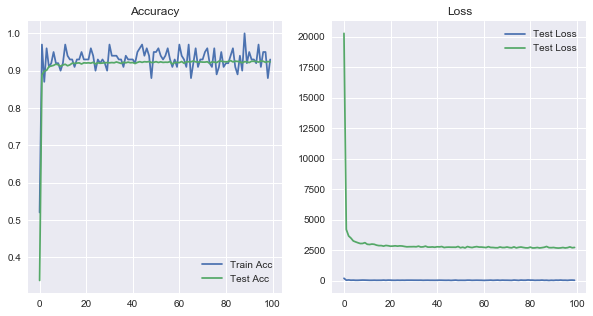

In [35]:
plt.figure(figsize=(10,5))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList, label="Train Acc");
plt.plot(testAccuracyList, label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList, label="Test Loss");
plt.plot(testLossList, label="Test Loss");
plt.title("Loss");
plt.legend();